# Plot clade connectivity between timepoints

To ensure that clades are connected between timepoints, enabling model fitting across timepoints for all clades, plot the first timepoint each clade occurs in a network and connect adjacent clades with edges based on traversal of the tips-to-clades map for all timepoints.

In [30]:
from collections import defaultdict
import json
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

plt.style.use("huddlej")

In [2]:
!pwd

/Users/jlhudd/projects/nextstrain/flu-forecasting/analyses


In [3]:
tips = pd.read_csv("../results/builds/h3n2/20_viruses_per_month/sample_0/2000-10-01--2015-10-01/standardized_tip_attributes.tsv",
                   sep="\t", parse_dates=["timepoint"])
tips = tips.loc[
    tips["segment"] == "ha",
    ["strain", "clade_membership", "timepoint", "frequency"]
].copy()

In [4]:
valid_tips = tips.strain.unique()

In [5]:
valid_tips.shape

(3678,)

In [6]:
data_path = "../results/builds/h3n2/20_viruses_per_month/sample_0/2000-10-01--2015-10-01/tips_to_clades.tsv"

In [7]:
df = pd.read_csv(data_path, sep="\t", parse_dates=["timepoint"])

In [8]:
df.shape

(785817, 6)

In [9]:
df.head()

,tip,clade_membership,depth,lineage,segment,timepoint
0,A/Canterbury/99/2000,caff4d6,0,h3n2,ha,2004-10-01
1,A/Canterbury/99/2000,9d101b5,1,h3n2,ha,2004-10-01
2,A/Canterbury/99/2000,2f661b6,2,h3n2,ha,2004-10-01
3,A/Canterbury/96/2000,4da990c,0,h3n2,ha,2004-10-01
4,A/Canterbury/96/2000,9d101b5,1,h3n2,ha,2004-10-01


In [10]:
df["tip"].isin(valid_tips).sum()

736528

In [11]:
df = df[df["tip"].isin(valid_tips)].copy()

In [12]:
df = tips.merge(df, left_on="strain", right_on="tip", suffixes=["_tip", ""]).copy()

In [13]:
sorted_df = df.sort_values(["timepoint", "tip", "depth"]).copy()

In [14]:
sorted_df.head()

,strain,clade_membership_tip,timepoint_tip,frequency,tip,clade_membership,depth,lineage,segment,timepoint
0,A/BacGiang/BG003/2004,3a81d99,2004-10-01,0.001207,A/BacGiang/BG003/2004,3a81d99,0,h3n2,ha,2004-10-01
1,A/BacGiang/BG003/2004,3a81d99,2004-10-01,0.001207,A/BacGiang/BG003/2004,4ff1302,4,h3n2,ha,2004-10-01
2,A/BacGiang/BG003/2004,3a81d99,2004-10-01,0.001207,A/BacGiang/BG003/2004,412c00a,12,h3n2,ha,2004-10-01
3,A/BacGiang/BG003/2004,3a81d99,2004-10-01,0.001207,A/BacGiang/BG003/2004,b32cea9,13,h3n2,ha,2004-10-01
4,A/BacGiang/BG003/2004,3a81d99,2004-10-01,0.001207,A/BacGiang/BG003/2004,4952842,14,h3n2,ha,2004-10-01


In [15]:
sorted_df["clade_membership"].unique().shape

(2078,)

In [16]:
timepoint_by_clade_name = sorted_df.groupby("clade_membership")["timepoint_tip"].min().to_dict()
timepoint_by_clade_name["root"] = df["timepoint"].min() - pd.DateOffset(months=6)

In [17]:
clade_id_by_name = {"root": 20}
clade_counter_by_timepoint = defaultdict(int)

for clade, timepoint in timepoint_by_clade_name.items():
    clade_id_by_name[clade] = clade_counter_by_timepoint[timepoint]
    clade_counter_by_timepoint[timepoint] += 5

Create a graph that will connect all adjacent clades (essentially the original tree) and note the first timepoint each clade was observed.

In [18]:
tree = nx.Graph()

#timepoint_by_clade_name = {"root": df["timepoint"].min() - pd.DateOffset(months=6)}
observed_tips = set()

for timepoint, timepoint_df in sorted_df.groupby("timepoint"):
    print(timepoint)
    for tip, tip_df in timepoint_df.groupby("tip"):
        # Only consider the clade linkages for tips once when that tip is first observed.
        if tip in observed_tips:
            continue
        
        observed_tips.add(tip)
        clades = tip_df["clade_membership"].values
        
        # Loop through clades, adding edges between adjacent clades.
        for i in range(len(clades)):
            # Make sure each clade is represented in the tree.
            tree.add_node(clades[i])

            # Link each clade after the first one back to its relative.
            if i > 0:
                tree.add_edge(clades[i], clades[i - 1])

            # Note the first timepoint each clade was observed.
            #if clades[i] not in timepoint_by_clade_name:
            #    timepoint_by_clade_name[clades[i]] = tip_timepoint
            #    clade_id_by_name[clades[i]] = clade_counter_by_timepoint[tip_timepoint]
            #    clade_counter_by_timepoint[tip_timepoint] += 5

2004-10-01 00:00:00
2005-04-01 00:00:00
2005-10-01 00:00:00
2006-04-01 00:00:00
2006-10-01 00:00:00
2007-04-01 00:00:00
2007-10-01 00:00:00
2008-04-01 00:00:00
2008-10-01 00:00:00
2009-04-01 00:00:00
2009-10-01 00:00:00
2010-04-01 00:00:00
2010-10-01 00:00:00
2011-04-01 00:00:00
2011-10-01 00:00:00
2012-04-01 00:00:00
2012-10-01 00:00:00
2013-04-01 00:00:00
2013-10-01 00:00:00
2014-04-01 00:00:00
2014-10-01 00:00:00
2015-04-01 00:00:00
2015-10-01 00:00:00


In [19]:
tip_df["timepoint_tip"].drop_duplicates().iloc[0]

Timestamp('2014-04-01 00:00:00')

In [20]:
tip

'A/Zaporizhia/324/2014'

In [21]:
#tree["root"]

In [22]:
tip_df

,strain,clade_membership_tip,timepoint_tip,frequency,tip,clade_membership,depth,lineage,segment,timepoint
1108077,A/Zaporizhia/324/2014,a139ba0,2014-04-01,0.003290,A/Zaporizhia/324/2014,a139ba0,0,h3n2,ha,2015-10-01
1108213,A/Zaporizhia/324/2014,a139ba0,2014-10-01,0.000408,A/Zaporizhia/324/2014,a139ba0,0,h3n2,ha,2015-10-01
1108078,A/Zaporizhia/324/2014,a139ba0,2014-04-01,0.003290,A/Zaporizhia/324/2014,dcc21f5,1,h3n2,ha,2015-10-01
1108214,A/Zaporizhia/324/2014,a139ba0,2014-10-01,0.000408,A/Zaporizhia/324/2014,dcc21f5,1,h3n2,ha,2015-10-01
1108079,A/Zaporizhia/324/2014,a139ba0,2014-04-01,0.003290,A/Zaporizhia/324/2014,7a8b37b,6,h3n2,ha,2015-10-01
1108215,A/Zaporizhia/324/2014,a139ba0,2014-10-01,0.000408,A/Zaporizhia/324/2014,7a8b37b,6,h3n2,ha,2015-10-01
1108080,A/Zaporizhia/324/2014,a139ba0,2014-04-01,0.003290,A/Zaporizhia/324/2014,1a16e36,14,h3n2,ha,2015-10-01
1108216,A/Zaporizhia/324/2014,a139ba0,2014-10-01,0.000408,A/Zaporizhia/324/2014,1a16e36,14,h3n2,ha,2015-10-01
1108081,A/Zaporizhia/324/2014,a139ba0,2014-04-01,0.003290,A/Zaporizhia/324/2014,66a66dd,26,h3n2,ha,2015-10-01
1108217,A/Zaporizhia/324/2014,a139ba0,2014-10-01,0.000408,A/Zaporizhia/324/2014,66a66dd,26,h3n2,ha,2015-10-01


In [23]:
tree.number_of_nodes()

2060

In [24]:
tree.number_of_edges()

3437

In [25]:
positions = {clade: (timepoint_by_clade_name[clade].year + ((timepoint_by_clade_name[clade].month - 1) / 12.0), clade_id_by_name[clade])
             for clade in timepoint_by_clade_name}

In [26]:
list(positions.items())[:10]

[('0001851', (2013.25, 0)),
 ('0003b07', (2007.25, 0)),
 ('003fccb', (2012.25, 0)),
 ('00979d7', (2011.75, 0)),
 ('00ca740', (2011.75, 5)),
 ('00d1bfe', (2010.75, 0)),
 ('0107ae0', (2007.75, 0)),
 ('011b759', (2014.75, 0)),
 ('011f34d', (2010.75, 5)),
 ('013a1ec', (2012.75, 0))]

In [34]:
edge_colors = []
for edge in tree.edges:
    delta = timepoint_by_clade_name[edge[1]] - timepoint_by_clade_name[edge[0]]
    if np.abs(delta.days) == 0:
        edge_colors.append("#ffffff")
    elif np.abs(delta.days) < 366:
        edge_colors.append("#cccccc")
    else:
        edge_colors.append("#000000")

In [35]:
valid_timepoints = sorted(set([position[0] for position in positions.values()]))

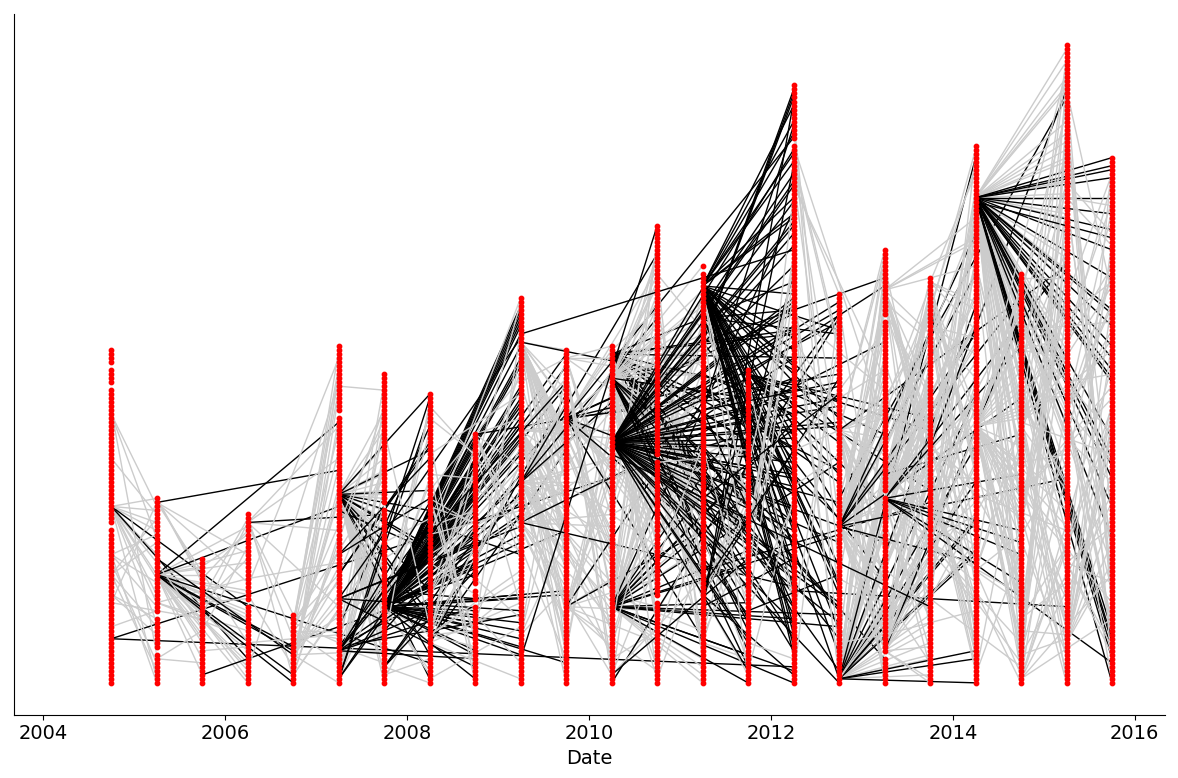

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

nx.draw(
    tree,
    pos=positions,
    ax=ax,
    node_size=10,
    edge_color=edge_colors,
    with_labels=False
)

ax.plot(valid_timepoints, [0.0] * len(valid_timepoints), alpha=0)
ax.set_xlabel("Date")
ax.set_yticks([])
plt.axis("on")
plt.tight_layout()

In [33]:
ax.set_yticks([])

[]

Look for nodes without any edges.

In [34]:
[node for node in tree if len(tree[node]) == 0]

[]

Look for nodes from the last timepoint that connect to nodes from more than one timepoint in the past.

In [35]:
recent_clades = [clade
                 for clade, timepoint in timepoint_by_clade_name.items()
                 if timepoint == df["timepoint"].max()]

In [36]:
recent_clades[:5]

['00be7ed', '016afa0', '0680f15', '0f126f1', '0f1c35c']

In [37]:
broken_clade = None
for recent_clade in recent_clades:
    for ancestor in tree[recent_clade]:
        delta = timepoint_by_clade_name[recent_clade] - timepoint_by_clade_name[ancestor]
        if delta.days > 190:
            print(delta)
            
        if delta.days > 370:
            print(recent_clade)
            broken_clade = recent_clade
            break
            
    if broken_clade is not None:
        break

365 days 00:00:00
365 days 00:00:00
548 days 00:00:00
12ee038


In [38]:
recent_clade

'12ee038'

In [39]:
broken_clade = "7d7cafb"

In [40]:
df[df["clade_membership"] == broken_clade].head()

,strain,clade_membership_tip,timepoint_tip,frequency,tip,clade_membership,depth,lineage,segment,timepoint


In [41]:
df[df["tip"] == "A/HongKong/4974/2011"].head()

,strain,clade_membership_tip,timepoint_tip,frequency,tip,clade_membership,depth,lineage,segment,timepoint


In [42]:
tips[tips["strain"] == "A/Okayama/28/2011"]

,strain,clade_membership,timepoint,frequency


In [43]:
df[df["clade_membership"] == broken_clade].shape

(0, 10)

In [44]:
bahia_df = df[(df["tip"] == "A/Bahia/100/2011") & (df["timepoint"] == "2012-04-01")]

In [45]:
bahia_df.head()

,strain,clade_membership_tip,timepoint_tip,frequency,tip,clade_membership,depth,lineage,segment,timepoint
1164205,A/Bahia/100/2011,e56a121,2011-04-01,0.000908,A/Bahia/100/2011,e56a121,0,h3n2,ha,2012-04-01
1164206,A/Bahia/100/2011,e56a121,2011-04-01,0.000908,A/Bahia/100/2011,026d21f,33,h3n2,ha,2012-04-01
1164207,A/Bahia/100/2011,e56a121,2011-04-01,0.000908,A/Bahia/100/2011,a08d8f5,35,h3n2,ha,2012-04-01
1164208,A/Bahia/100/2011,e56a121,2011-04-01,0.000908,A/Bahia/100/2011,4786bbf,36,h3n2,ha,2012-04-01
1164209,A/Bahia/100/2011,e56a121,2011-04-01,0.000908,A/Bahia/100/2011,956f201,39,h3n2,ha,2012-04-01


In [46]:
parana_df = df[(df["tip"] == "A/Parana/415/2012") & (df["timepoint"] == "2012-10-01")]

In [47]:
parana_df

,strain,clade_membership_tip,timepoint_tip,frequency,tip,clade_membership,depth,lineage,segment,timepoint
1493446,A/Parana/415/2012,f0f996e,2012-10-01,0.001553,A/Parana/415/2012,f0f996e,0,h3n2,ha,2012-10-01
1493447,A/Parana/415/2012,f0f996e,2012-10-01,0.001553,A/Parana/415/2012,dbdf9a1,9,h3n2,ha,2012-10-01
1493448,A/Parana/415/2012,f0f996e,2012-10-01,0.001553,A/Parana/415/2012,e56a121,11,h3n2,ha,2012-10-01
1493449,A/Parana/415/2012,f0f996e,2012-10-01,0.001553,A/Parana/415/2012,026d21f,40,h3n2,ha,2012-10-01
1493450,A/Parana/415/2012,f0f996e,2012-10-01,0.001553,A/Parana/415/2012,a08d8f5,42,h3n2,ha,2012-10-01
1493451,A/Parana/415/2012,f0f996e,2012-10-01,0.001553,A/Parana/415/2012,956f201,45,h3n2,ha,2012-10-01
1493452,A/Parana/415/2012,f0f996e,2012-10-01,0.001553,A/Parana/415/2012,f321e53,46,h3n2,ha,2012-10-01
1493453,A/Parana/415/2012,f0f996e,2012-10-01,0.001553,A/Parana/415/2012,e84bec9,47,h3n2,ha,2012-10-01
1493454,A/Parana/415/2012,f0f996e,2012-10-01,0.001553,A/Parana/415/2012,41bb3e2,48,h3n2,ha,2012-10-01
1493455,A/Parana/415/2012,f0f996e,2012-10-01,0.001553,A/Parana/415/2012,def5c7a,63,h3n2,ha,2012-10-01


In [48]:
tips[tips["strain"] == "A/Bahia/100/2011"]

,strain,clade_membership,timepoint,frequency
3489,A/Bahia/100/2011,e56a121,2011-04-01,0.000908
3859,A/Bahia/100/2011,f0f996e,2011-10-01,0.000636


In [49]:
tips[tips["strain"] == "A/HoChiMinh/6388/2010"]

,strain,clade_membership,timepoint,frequency


In [50]:
# Identify distinct clades per timepoint.
clades = tips.loc[:, ["timepoint", "clade_membership"]].drop_duplicates().copy()
clades = clades.rename(columns={"timepoint": "initial_timepoint"})

In [51]:
clades[clades["clade_membership"] == "93a23e6"]

,initial_timepoint,clade_membership


In [52]:
df[df["clade_membership"] == "93a23e6"]

,strain,clade_membership_tip,timepoint_tip,frequency,tip,clade_membership,depth,lineage,segment,timepoint


In [53]:
clades[clades["initial_timepoint"] == "2012-04-01"].head()

,initial_timepoint,clade_membership
4192,2012-04-01,5702c76
4193,2012-04-01,f2ec31a
4194,2012-04-01,a0380c9
4195,2012-04-01,8cd07d4
4196,2012-04-01,3e510d8


In [54]:
clades[clades["initial_timepoint"] == "2012-10-01"].head()

,initial_timepoint,clade_membership
4602,2012-10-01,77c2a55
4603,2012-10-01,5702c76
4604,2012-10-01,a0380c9
4605,2012-10-01,8cd07d4
4606,2012-10-01,c139e7c


In [55]:
final_clade_frequencies = pd.read_table("../results/builds/h3n2/5_viruses_per_month/sample_0/2000-10-01--2015-10-01/final_clade_frequencies.tsv")

In [56]:
final_clade_frequencies.groupby(["initial_timepoint", "clade_membership"])["frequency"].sum()

initial_timepoint  clade_membership
2004-10-01         00ed6d2             0.000000
                   21b8d11             0.000000
                   482757a             0.000000
                   4ad176b             0.000000
                   57fdf76             0.000000
                   5c72121             0.000000
                   5cbfb7d             0.000000
                   6e5d388             0.000000
                   74907c6             0.000000
                   84dfd90             0.000037
                   8f3fc76             0.000000
                   9415e47             0.000000
                   993737c             0.816643
                   b1c31e8             0.010778
                   d13edda             0.000030
                   d22442e             0.000000
                   d5dbb5e             0.000000
                   dc76926             0.000000
                   e5a7ac4             0.077351
                   e712c33             0.000000
    

In [57]:
clade_counts = final_clade_frequencies.groupby(["initial_timepoint", "clade_membership"])["frequency"].sum().reset_index()

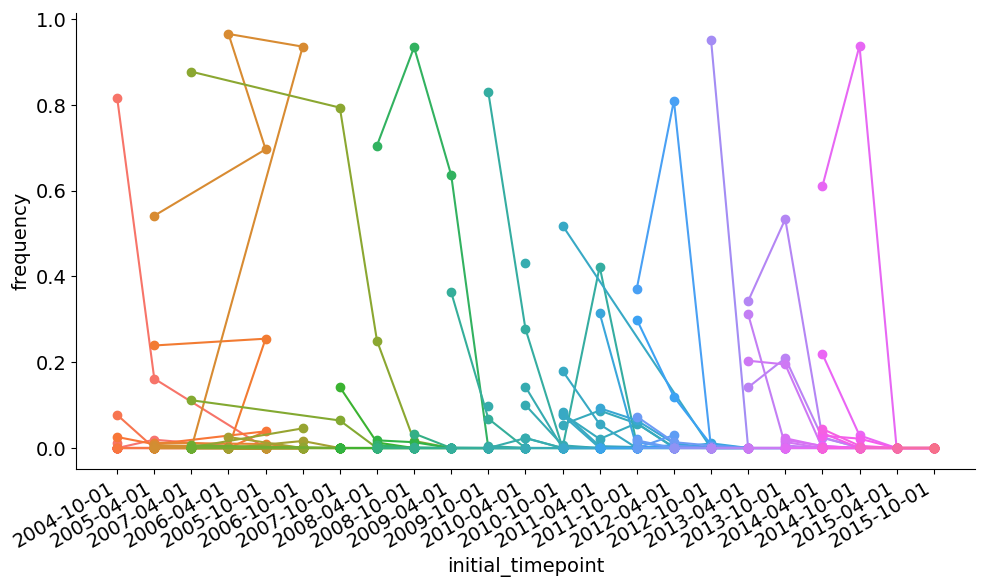

In [58]:
g = sns.FacetGrid(clade_counts, hue="clade_membership", height=6, aspect=1.7)
g.map(plt.plot, "initial_timepoint", "frequency", marker="o")
#g.axes.flatten()[0].set_ylim(0, 1)
plt.gcf().autofmt_xdate()

## Reattempt clade connectivity plots

Build the table of future tips by clade for all distinct clades by timepoint, plot those clades by timepoint, and then plot connections between clades at timepoints where future tip frequencies are non-zero.

In [59]:
delta_months = 12
primary_segment = "ha"
delta_time_offset = pd.DateOffset(months=delta_months)

In [62]:
tips = pd.read_csv("../results/builds/h3n2/20_viruses_per_month/sample_0/2000-10-01--2015-10-01/standardized_tip_attributes.tsv",
                   sep="\t", parse_dates=["timepoint"])
tips = tips.loc[
    tips["segment"] == "ha",
    ["strain", "clade_membership", "timepoint", "frequency"]
].copy()

In [63]:
tips.head()

,strain,clade_membership,timepoint,frequency
0,A/Aichi/181/2004,4ff1302,2004-10-01,0.003256
1,A/Aichi/183/2004,b51374a,2004-10-01,0.003087
2,A/Anhui/789/2004,213327e,2004-10-01,0.003449
3,A/Argentina/126/2004,a18c764,2004-10-01,0.004187
4,A/Argentina/26/2004,809d82c,2004-10-01,0.002362


In [64]:
tips.groupby(["timepoint", "clade_membership"])["frequency"].sum().reset_index().sort_values(["timepoint", "frequency"])

,timepoint,clade_membership,frequency
31,2004-10-01,4452492,0.000001
56,2004-10-01,6ef52d8,0.000002
46,2004-10-01,59f0604,0.000005
61,2004-10-01,7c5d06a,0.000006
34,2004-10-01,4549427,0.000007
90,2004-10-01,bef6aa8,0.000009
65,2004-10-01,8d5bd42,0.000011
54,2004-10-01,6cb4d6e,0.000012
2,2004-10-01,089c686,0.000013
64,2004-10-01,8d3345d,0.000013


In [65]:
# Identify distinct clades per timepoint.
clades = tips.groupby(["timepoint", "clade_membership"])["frequency"].sum().reset_index().sort_values(["timepoint", "frequency"]).copy()
clades = clades.rename(columns={"timepoint": "initial_timepoint"})
clades = clades.drop(columns="frequency")

In [66]:
# Annotate future timepoint.
clades["final_timepoint"] = clades["initial_timepoint"] + delta_time_offset

In [67]:
clades.head()

,initial_timepoint,clade_membership,final_timepoint
31,2004-10-01,4452492,2005-10-01
56,2004-10-01,6ef52d8,2005-10-01
46,2004-10-01,59f0604,2005-10-01
61,2004-10-01,7c5d06a,2005-10-01
34,2004-10-01,4549427,2005-10-01


In [68]:
for timepoint, timepoint_df in clades.groupby("initial_timepoint"):
    clades.loc[clades["initial_timepoint"] == timepoint, "y"] = np.arange(len(timepoint_df))

In [69]:
clades.head(20)

,initial_timepoint,clade_membership,final_timepoint,y
31,2004-10-01,4452492,2005-10-01,0.0
56,2004-10-01,6ef52d8,2005-10-01,1.0
46,2004-10-01,59f0604,2005-10-01,2.0
61,2004-10-01,7c5d06a,2005-10-01,3.0
34,2004-10-01,4549427,2005-10-01,4.0
90,2004-10-01,bef6aa8,2005-10-01,5.0
65,2004-10-01,8d5bd42,2005-10-01,6.0
54,2004-10-01,6cb4d6e,2005-10-01,7.0
2,2004-10-01,089c686,2005-10-01,8.0
64,2004-10-01,8d3345d,2005-10-01,9.0


In [70]:
# Load mapping of tips to all possible clades at each timepoint.
tips_to_clades = pd.read_csv("../results/builds/h3n2/20_viruses_per_month/sample_0/2000-10-01--2015-10-01/tips_to_clades.tsv", sep="\t", parse_dates=["timepoint"])
tips_to_clades = tips_to_clades.loc[
    tips_to_clades["segment"] == primary_segment,
    ["tip", "clade_membership", "depth", "timepoint"]
].copy()

In [71]:
# Get all tip-clade combinations by timepoint for the distinct clades.
future_tips_by_clades = clades.merge(
    tips_to_clades,
    how="inner",
    left_on=["final_timepoint", "clade_membership"],
    right_on=["timepoint", "clade_membership"]
)

In [72]:
# Drop redundant columns.
future_tips_by_clades = future_tips_by_clades.drop(
    columns=["timepoint"]
)

In [73]:
future_tips_by_clades.head()

,initial_timepoint,clade_membership,final_timepoint,y,tip,depth
0,2004-10-01,4452492,2005-10-01,0.0,A/Shaanxi/27/2003,0
1,2004-10-01,6ef52d8,2005-10-01,1.0,A/Newcastle/1/2004,0
2,2004-10-01,59f0604,2005-10-01,2.0,A/Brisbane/1/2004,0
3,2004-10-01,7c5d06a,2005-10-01,3.0,A/Malaysia/1/2004,0
4,2004-10-01,4549427,2005-10-01,4.0,A/Kobe/3/2004,0


In [74]:
# Get the closest clade to each tip by timepoint. This relies on records
# being sorted by depth of clade from tip.
future_tips_by_clades = future_tips_by_clades.sort_values(["initial_timepoint", "tip", "depth"]).groupby(["initial_timepoint"\
, "tip"]).first().reset_index()

In [75]:
future_tips_by_clades.head()

,initial_timepoint,tip,clade_membership,final_timepoint,y,depth
0,2004-10-01,A/Aichi/164/2005,58ffa77,2005-10-01,102.0,1
1,2004-10-01,A/Aichi/165/2005,7aa732d,2005-10-01,38.0,29
2,2004-10-01,A/Aichi/167/2005,7aa732d,2005-10-01,38.0,22
3,2004-10-01,A/Aichi/181/2004,4ff1302,2005-10-01,98.0,0
4,2004-10-01,A/Aichi/183/2004,b51374a,2005-10-01,53.0,0


In [76]:
future_tips_by_clades[future_tips_by_clades["tip"] == "A/Aichi/114/2008"]

,initial_timepoint,tip,clade_membership,final_timepoint,y,depth


In [77]:
# Get frequencies of future tips associated with current clades.
future_clade_frequencies = future_tips_by_clades.merge(tips, how="inner", left_on=["tip", "final_timepoint"], right_on=["strain", "timepoint"], suffixes=["", "_tip"])
future_clade_frequencies = future_clade_frequencies.drop(
    columns=[
        "tip",
        "depth",
        "clade_membership_tip",
        "timepoint"
    ]
)

In [78]:
future_clade_frequencies.head()

,initial_timepoint,clade_membership,final_timepoint,y,strain,frequency
0,2004-10-01,58ffa77,2005-10-01,102.0,A/Aichi/164/2005,0.001025
1,2004-10-01,7aa732d,2005-10-01,38.0,A/Aichi/165/2005,0.001355
2,2004-10-01,7aa732d,2005-10-01,38.0,A/Aichi/167/2005,0.001302
3,2004-10-01,7aa732d,2005-10-01,38.0,A/Anhui/1179/2005,0.010636
4,2004-10-01,7aa732d,2005-10-01,38.0,A/Anhui/1238/2005,0.009978


In [79]:
future_clade_frequencies.groupby("initial_timepoint")["frequency"].sum()

initial_timepoint
2004-10-01    0.964599
2005-04-01    0.998792
2005-10-01    1.000009
2006-04-01    0.999998
2006-10-01    0.999997
2007-04-01    1.000000
2007-10-01    1.000002
2008-04-01    0.999994
2008-10-01    1.000001
2009-04-01    0.999998
2009-10-01    0.996692
2010-04-01    0.999995
2010-10-01    0.999990
2011-04-01    0.991793
2011-10-01    0.991572
2012-04-01    0.999686
2012-10-01    0.995549
2013-04-01    0.999921
2013-10-01    0.999141
2014-04-01    1.000002
2014-10-01    0.999980
Name: frequency, dtype: float64

(0.9, 1.02)

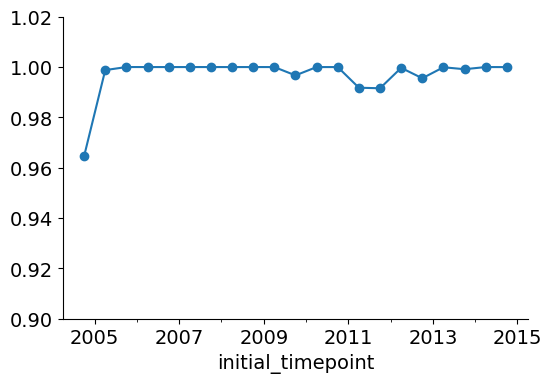

In [80]:
ax = future_clade_frequencies.groupby("initial_timepoint")["frequency"].sum().plot(marker="o")
ax.set_ylim(0.9, 1.02)

In [81]:
future_clades = future_clade_frequencies.loc[:, ["initial_timepoint", "final_timepoint", "clade_membership"]].drop_duplicates()

In [82]:
clades.shape

(4029, 4)

In [83]:
clades.head()

,initial_timepoint,clade_membership,final_timepoint,y
31,2004-10-01,4452492,2005-10-01,0.0
56,2004-10-01,6ef52d8,2005-10-01,1.0
46,2004-10-01,59f0604,2005-10-01,2.0
61,2004-10-01,7c5d06a,2005-10-01,3.0
34,2004-10-01,4549427,2005-10-01,4.0


In [84]:
future_clades.shape

(319, 3)

In [85]:
future_clades["color"] = "#999999"

In [86]:
future_clades.head()

,initial_timepoint,final_timepoint,clade_membership,color
0,2004-10-01,2005-10-01,58ffa77,#999999
1,2004-10-01,2005-10-01,7aa732d,#999999
15,2004-10-01,2005-10-01,aaeb03c,#999999
29,2004-10-01,2005-10-01,bc3cfcc,#999999
31,2004-10-01,2005-10-01,22ada0a,#999999


In [87]:
clades.head()

,initial_timepoint,clade_membership,final_timepoint,y
31,2004-10-01,4452492,2005-10-01,0.0
56,2004-10-01,6ef52d8,2005-10-01,1.0
46,2004-10-01,59f0604,2005-10-01,2.0
61,2004-10-01,7c5d06a,2005-10-01,3.0
34,2004-10-01,4549427,2005-10-01,4.0


In [88]:
clades.shape

(4029, 4)

In [89]:
clades_with_future_clades = clades.merge(future_clades, how="left", on=["initial_timepoint", "final_timepoint", "clade_membership"])

In [90]:
clades_with_future_clades.loc[pd.isnull(clades_with_future_clades["color"]), "color"] = "#cccccc"

In [91]:
clades_with_future_clades.head()

,initial_timepoint,clade_membership,final_timepoint,y,color
0,2004-10-01,4452492,2005-10-01,0.0,#cccccc
1,2004-10-01,6ef52d8,2005-10-01,1.0,#cccccc
2,2004-10-01,59f0604,2005-10-01,2.0,#cccccc
3,2004-10-01,7c5d06a,2005-10-01,3.0,#cccccc
4,2004-10-01,4549427,2005-10-01,4.0,#cccccc


In [92]:
tips[tips["clade_membership"] == "8c6e6c2"]

,strain,clade_membership,timepoint,frequency


In [93]:
clades_with_future_clades[clades_with_future_clades["color"] == "#cccccc"].shape

(3710, 5)

In [94]:
clades_with_future_clades[clades_with_future_clades["color"] == "#cccccc"].merge(tips, left_on=["initial_timepoint", "clade_membership"],
                                                                                 right_on=["timepoint", "clade_membership"]).groupby(
    ["initial_timepoint", "clade_membership"]
)["frequency"].count()

initial_timepoint  clade_membership
2004-10-01         0296d71              1
                   04064de              1
                   089c686              1
                   094757b              2
                   0f370ba              1
                   1011fd7              1
                   101bf45              1
                   11f04dd              1
                   166a262              1
                   19ed4b7              1
                   1dcd826              3
                   213327e              1
                   2443c3c              1
                   24a0bd0              1
                   27e99b9              2
                   2845d21              1
                   2c4c1a7              1
                   30bedca              1
                   31c73a7              1
                   31e4ba2              5
                   356fb9f              1
                   37b0f41              1
                   3a0d378              

In [95]:
tips[tips["clade_membership"] == "a54d1ad"]

,strain,clade_membership,timepoint,frequency


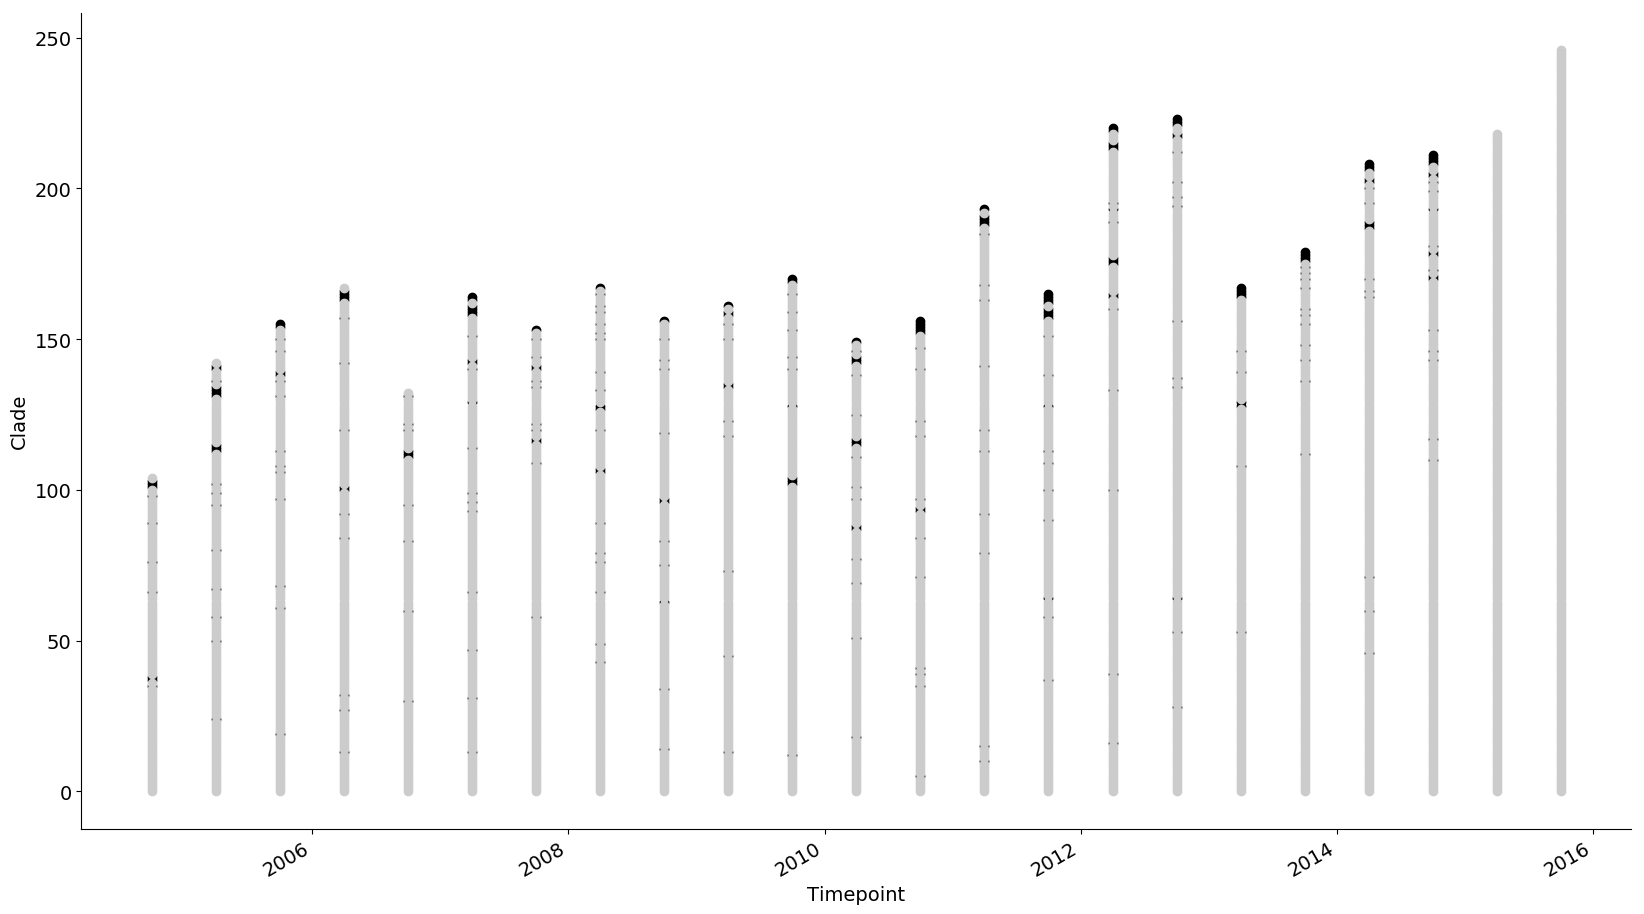

In [99]:
fig, ax = plt.subplots(1, 1, figsize=(20, 12))

present = clades_with_future_clades[clades_with_future_clades["color"] == "#999999"]
ax.plot(present["initial_timepoint"], present["y"], "o", linestyle="", c="#000000")

absent = clades_with_future_clades[clades_with_future_clades["color"] == "#cccccc"]
ax.plot(absent["initial_timepoint"], absent["y"], "o", linestyle="", c="#cccccc")

ax.set_xlabel("Timepoint")
ax.set_ylabel("Clade")
plt.gcf().autofmt_xdate()